In [1]:
from netgen.geom2d import SplineGeometry  # SplieGeometry to define a 2D mesh

from ngsolve import * # import everything from the ngsolve module
from ngsolve.webgui import Draw

import numpy as np

from interpolations import InterpolateLevelSetToElems # function which interpolates a levelset function

myMAXH = 0.05
EPS = myMAXH * 1e-6      #variable defining when a point is on the interface and when not

geo = SplineGeometry()

R = 2

## add a rectangle
geo.AddRectangle(p1=(-R,-R),
                 p2=(R,R),
                 bc="rectangle",
                 leftdomain=1,
                 rightdomain=0)



geo.SetMaterial (1, "outer") # give the domain the name "outer"

mesh = Mesh(geo.GenerateMesh(maxh=myMAXH)) # generate ngsolve mesh
# H1-conforming finite element space

fes_state = H1(mesh, order=1, dirichlet="rectangle")
fes_adj = H1(mesh, order=1, dirichlet="rectangle")
fes_level = H1(mesh, order=1)

pwc = L2(mesh)   #piecewise constant space


## test and trial functions
u, v = fes_state.TnT()

p, q = fes_adj.TnT()

gfu = GridFunction(fes_state)
gfp = GridFunction(fes_adj)

gfud = GridFunction(fes_state)

psi = GridFunction(fes_level)
psi.Set(-1)

psides = GridFunction(fes_level)
psinew = GridFunction(fes_level)

# constants for f_rhs and beta
f1 = 10
f2 = 1

beta1 = 10
beta2 = 1

# piecewise constant coefficient functions beta and f_rhs

beta = GridFunction(pwc)
beta.Set(beta1)

f_rhs = GridFunction(pwc)
f_rhs.Set(f1)

# bilinear form for state equation
B = BilinearForm(fes_state)
B += beta*grad(u) * grad(v) * dx


B_adj = BilinearForm(fes_adj)
B_adj += beta*grad(p) * grad(q) * dx


L = LinearForm(fes_state)
L += f_rhs * v *dx

duCost = LinearForm(fes_adj)

# solving
psides.Set(-1)
InterpolateLevelSetToElems(psides, beta1, beta2, beta, mesh, EPS)
InterpolateLevelSetToElems(psides, f1, f2, f_rhs, mesh, EPS)

B.Assemble()
L.Assemble()

inv = B.mat.Inverse(fes_state.FreeDofs(), inverse="sparsecholesky") # inverse of bilinear form

gfu.vec.data = inv*L.vec

scene_u = Draw(gfu)
mesh.nv,mesh.ne

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

(7571, 14820)

In [2]:
a = 4.0/5.0
b = 2
f = CoefficientFunction( 0.1*( (sqrt((x - a)**2 + b * y**2) - 1) \
                * (sqrt((x + a)**2 + b * y**2) - 1) \
                * (sqrt(b * x**2 + (y - a)**2) - 1) \
                * (sqrt(b * x**2 + (y + a)**2) - 1) - 0.001) )

psides.Set(f)
InterpolateLevelSetToElems(psides, beta1, beta2, beta, mesh, EPS)
InterpolateLevelSetToElems(psides, f1, f2, f_rhs, mesh, EPS)

B.Assemble()
L.Assemble()
inv = B.mat.Inverse(fes_state.FreeDofs(), inverse="sparsecholesky") # inverse of bilinear form

gfud.vec.data = inv*L.vec

Draw(gfud, mesh, 'gfud')

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

In [3]:
def SolvePDE(adjoint=False):
    #Newton(a, gfu, printing = False, maxerr = 3e-9)

    B.Assemble()
    L.Assemble()

    inv_state = B.mat.Inverse(fes_state.FreeDofs(), inverse="sparsecholesky")

    # solve state equation
    gfu.vec.data = inv_state*L.vec

    if adjoint == True:
        # solve adjoint state equatoin
        duCost.Assemble()
        B_adj.Assemble()
        inv_adj = B_adj.mat.Inverse(fes_state.FreeDofs(), inverse="sparsecholesky")
        gfp.vec.data = -inv_adj * duCost.vec
    scene_u.Redraw()

InterpolateLevelSetToElems(psi, beta1, beta2, beta, mesh, EPS)
InterpolateLevelSetToElems(psi, f1, f2, f_rhs, mesh, EPS)

SolvePDE()

# define the cost function
def Cost(u):
    return (u - gfud)**2*dx

# derivative of cost function
duCost += 2*(gfu-gfud) * q * dx

print("initial cost = ", Integrate(Cost(gfu), mesh))
print(fes_state.ndof)

initial cost =  39.293621292183445
7571


In [4]:
BetaPosNeg = 2 * beta2 * (beta1-beta2)/(beta1+beta2)    # factors in TD in positive part {x: \psi(x)>0} ={x: \beta(x) = \beta_2}
BetaNegPos = 2 * beta1 * (beta1-beta2)/(beta1+beta2)    # factors in TD in positive part {x: \psi(x)>0} ={x: \beta(x) = \beta_2}
FPosNeg = -(f1-f2)

psinew.vec.data = psi.vec

## normalise psi in L2
# normPsi = sqrt(Integrate(psi**2*dx, mesh))
# psi.vec.data = 1/normPsi * psi.vec

kappa = 0.05

# set level set function to data
InterpolateLevelSetToElems(psi, beta1, beta2, beta, mesh, EPS)
InterpolateLevelSetToElems(psi, f1, f2, f_rhs, mesh, EPS)

Redraw()

TD_node = GridFunction(fes_level)
#g_k = GridFunction(fes_level)
#scene1 = Draw(TD_node, mesh, "TD_node")

TD_pwc = GridFunction(pwc)
#scene2 = Draw(TD_pwc, mesh, "TD_pwc")

TDPosNeg_pwc = GridFunction(pwc)
TDNegPos_pwc = GridFunction(pwc)

cutRatio = GridFunction(pwc)

# solve for current configuration
SolvePDE(adjoint=True)

In [5]:
iter_max = 2000
converged = False

costs = []
iterations = [] 
thetas = []
active_dofs = []
N = fes_state.ndof
theta_tolerance = 1.5
xm=0.
ym=0.
psi.Set( (x-xm)**2+(y-ym)**2-0.25**2)
psinew.vec.data= psi.vec
scene_u = Draw(gfu)
scene_psi = Draw(IfPos(psi,1,-1),mesh)
J = Integrate(Cost(gfu),mesh)

for i in range(4):
    costs.append(J)

with TaskManager():

    for k in range(iter_max):
        print("================ iteration ", k, "===================")

        # copy new levelset data from psinew into psi
        psi.vec.data = psinew.vec
        scene_psi.Redraw()


        SolvePDE(adjoint=True)
        scene_u.Redraw()

        J_current = Integrate(Cost(gfu),mesh)
        costs.append(J_current)
        last_five_costs = costs[-5:]
        max_last_five = max(last_five_costs) #  for the line search
        print("cost in beginning of iteration", k, ": Cost = ", J_current)
        print("Maximum cost in last 5 iterations = ",max_last_five) 

        # compute the piecewise constant topological derivative in each domain
        TDPosNeg_pwc.Set( BetaPosNeg * grad(gfu) * grad(gfp)  + FPosNeg*gfp )
        TDNegPos_pwc.Set( BetaNegPos * grad(gfu) * grad(gfp)  + FPosNeg*gfp )

        # compute the cut ratio of the interface elements
        InterpolateLevelSetToElems(psi, 1, 0, cutRatio, mesh, EPS)

        # compute the combined topological derivative using the cut ratio information
        for j in range(len(TD_pwc.vec)):
            TD_pwc.vec[j] = cutRatio.vec[j] * TDNegPos_pwc.vec[j] + (1-cutRatio.vec[j])*TDPosNeg_pwc.vec[j]

        TD_node.Set(TD_pwc)

        normTD = sqrt(Integrate(TD_node**2*dx, mesh)) # L2 norm of TD_node
        

        normPsi = sqrt(Integrate(psi**2*dx, mesh)) # L2 norm of psi

########################################################################################
        # FIRST STOPPING CRITERION
        arg_arc = Integrate(psi*TD_node,mesh)/(normTD*normPsi)
        theta_k = np.arccos(arg_arc)*180/np.pi
        print("Theta_k =",theta_k,"  degrees")
        thetas.append(theta_k)

        if theta_k < theta_tolerance:
            print("Theta Converged, theta = ", theta_k,"    degrees")
            break
        # SECOND STOPPING CRITERION  
        indices = []
        for i in range(N):
                if (psi.vec[i] < 0) and (TD_node.vec[i] > 0):#In Omega  -DJ>0 mm DJ < 0 , NOT optimal
                    indices.append(i)
                elif(psi.vec[i] > 0) and (TD_node.vec[i] < 0): #OUT Omega , NOT optimal
                    indices.append(i)
        active_dofs.append(len(indices))
        print("Non optimals =" ,len(indices),"out of", N)
        if (len(indices) < int(0.001*N)) and (k > 4) :
            print("99.5% of elements satisfy optimality conditions, non optimal elements are",len(indices) ," out of ",N )
            break


        
        iterations.append(k)
        ##################################################
        psi.vec.data = 1/normPsi * psi.vec  # normalised psi
        TD_node.vec.data = 1/normTD * TD_node.vec # normalised TD_node
        
        for j in range(10):

            # update the level set function
            psinew.vec.data = (1-kappa)*psi.vec + kappa*TD_node.vec
            # update beta and f_rhs
            InterpolateLevelSetToElems(psinew, beta1, beta2, beta, mesh, EPS)
            InterpolateLevelSetToElems(psinew, f1, f2, f_rhs, mesh, EPS)

            # solve PDE without adjoint
            SolvePDE()

            Redraw(blocking=True)

            Jnew = Integrate(Cost(gfu), mesh)

            if Jnew > J_current:
                print("--------------------")
                print("-----line search ---")
                print("--------------------")
                kappa = kappa*0.8
             #   kappa = max(0.0001,kappa)
                print("kappa", kappa)
            else:
                break

        Redraw(blocking=True)
        print("----------- Jnew in  iteration ", k, " = ", Jnew, " (kappa = ", kappa, ")")
        print('')
        print("iter" + str(k) + ", Jnew = " + str(Jnew) + " (kappa = ", kappa, ")")
        kappa = min(1, kappa*1.2)

        print("end of iter " + str(k))

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

================ iteration  0 ===================
cost in beginning of iteration 0 : Cost =  39.293621292183474
Maximum cost in last 5 iterations =  39.293621292183474
Theta_k = 106.4372094670999   degrees
Non optimals = 6163 out of 7571
----------- Jnew in  iteration  0  =  11.858507874151247  (kappa =  0.05 )

iter0, Jnew = 11.858507874151247 (kappa =  0.05 )
end of iter 0
================ iteration  1 ===================
cost in beginning of iteration 1 : Cost =  11.85850787415086
Maximum cost in last 5 iterations =  39.293621292183474
Theta_k = 96.70697915865668   degrees
Non optimals = 5017 out of 7571
----------- Jnew in  iteration  1  =  6.366198991449459  (kappa =  0.06 )

iter1, Jnew = 6.366198991449459 (kappa =  0.06 )
end of iter 1
================ iteration  2 ===================
cost in beginning of iteration 2 : Cost =  6.366198991449488
Maximum cost in last 5 iterations =  39.293621292183474
Theta_k = 93.6793469278351   degrees
Non optimals = 5379 out of 7571
-----------

KeyboardInterrupt: 

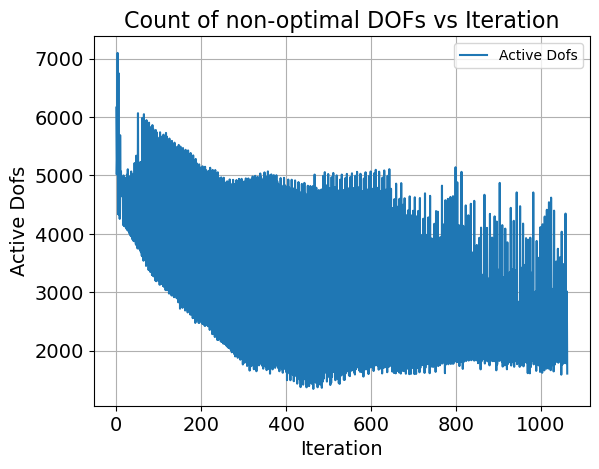

In [11]:
import matplotlib.pyplot as plt# Figure 1: Norm vs Iteration
plt.figure()
plt.plot(iterations, active_dofs, label='Active Dofs')
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Active Dofs', fontsize=14)
plt.title('Count of non-optimal DOFs vs Iteration', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend()
plt.grid(True)
#plt.savefig(".png")
plt.show()


In [7]:
import csv

# Save data to CSV
with open('Non_Optimal_points_ref77.csv', 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['Iterations', 'N_dof'])
    for i in range(len(iterations)-1):
        csvwriter.writerow([iterations[i], active_dofs[i]])

print("Data saved to data.csv")


Data saved to data.csv


In [8]:
import csv

# Save data to CSV
with open('Thetas_ref77.csv', 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['Iterations', 'N_dof'])
    for i in range(len(iterations)-1):
        csvwriter.writerow([iterations[i], thetas[i]])

print("Data saved to data.csv")

Data saved to data.csv


In [13]:
print(np.min(TD_node.vec),np.max(TD_node.vec))

-0.396209935085226 2.399777978104799
